In [171]:
import numpy as np
from astropy.table import Table, join
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib.pyplot as plt

Used following query to get GAIA data (https://gea.esac.esa.int/archive/)
```SQL
SELECT t.source_id, t.ra, t.dec, i.redshift_qsoc, i.classlabel_dsc 
FROM gaiadr3.gaia_source AS t, gaiadr3.qso_candidates AS i
WHERE t.source_id = i.source_id AND t.dec < 6.0 AND t.dec > -3.0 AND t.ra > 125 AND t.ra < 148 
```

Using eFEDS Cluster Catalogues ID 10 and 11 (from https://erosita.mpe.mpg.de/edr/eROSITAObservations/Catalogues/)<br>
All are in CSV format so they are easier to use.

In [172]:
gaia_sources = Table.read('Source_Data/Gaia_QSO_data-result.csv')
print(len(gaia_sources))
gaia_sources[0]

22615


source_id,ra,dec,redshift_qsoc,classlabel_dsc
str19,float64,float64,float64,str14
3089654921323997696,125.01336169710326,1.1099643335828642,1.5718781,quasar


Only include quasars in Gaia sources

In [173]:
gaia_sources = gaia_sources[gaia_sources['classlabel_dsc']=='quasar']
print(len(gaia_sources))

15192


Remove Unused columns from cluster tables

In [174]:
eFEDS_clusters = Table.read('Source_Data/eFEDS_Clusters.csv')
eFEDS_clusters = eFEDS_clusters['ID', 'ID_SRC', 'RA', 'DEC', 'z']
print(len(eFEDS_clusters))
eFEDS_clusters[eFEDS_clusters['ID_SRC']==38]

542


ID,ID_SRC,RA,DEC,z
str22,int32,float64,float64,float64
eFEDS J093712.8+031651,38,144.3035678286463,3.281043248079495,0.24744


In [175]:
eFEDS_clusters_CTP = Table.read('Source_Data/eFEDS_Clusters_CTP.csv')
eFEDS_clusters_CTP = eFEDS_clusters_CTP['Name', 'ID_SRC', 'F_CONT_BEST_COMB']
print(len(eFEDS_clusters_CTP))
eFEDS_clusters_CTP[0]

542


Name,ID_SRC,F_CONT_BEST_COMB
str22,int32,float64
eFEDS J093712.9+031652,38,0.124957


Only Select clusters with a F_CONT_BEST_COMB $< 0.3$

In [176]:
eFEDS_clusters_CTP = eFEDS_clusters_CTP[eFEDS_clusters_CTP['F_CONT_BEST_COMB']<0.2]
eFEDS_clusters_confirmed = join(eFEDS_clusters, eFEDS_clusters_CTP, keys = 'ID_SRC')
eFEDS_clusters_confirmed.remove_column('Name')# this is not needed anymore
print(len(eFEDS_clusters_confirmed))
eFEDS_clusters_confirmed[0]

453


ID,ID_SRC,RA,DEC,z,F_CONT_BEST_COMB
str22,int32,float64,float64,float64,float64
eFEDS J093712.8+031651,38,144.3035678286463,3.281043248079495,0.24744,0.124957


Remove rejected clusters from the table (Rejected list from Table A2 in https://arxiv.org/pdf/2109.11807.pdf)

In [177]:
rejection_list= [1644,3334,8602,5909,8922,9463,13484,13299,11754,5702,6840]
for reject_id in rejection_list:
    mask = eFEDS_clusters_confirmed['ID_SRC'] != reject_id
    eFEDS_clusters_confirmed = eFEDS_clusters_confirmed[mask]

print(len(eFEDS_clusters_confirmed))

448


Cross match Gaia sources to clusters within 5 arcmins

In [178]:
five_arcmin = 0.08333333  # degrees

eFEDS_gaia_match = Table(names=('Cluster_ID', 'Cluster_ID_SRC', 'Cluster_RA', 'Cluster_DEC', 'Cluster_z', 'source_id',
                                'source_ra', 'source_dec', 'source_redshift', 'separation'),
                         dtype=('S', 'i', 'f', 'f', 'f', 'S', 'f', 'f', 'f', 'f'))

for cluster in eFEDS_clusters_confirmed:
    ra_1 = np.radians(cluster['RA'])
    dec_1 = np.radians(cluster['DEC'])

    ra_2 = np.radians(gaia_sources['ra'])
    dec_2 = np.radians(gaia_sources['dec'])

    separation = np.arccos(np.sin(dec_2)*np.sin(dec_1) +
                           np.cos(dec_2)*np.cos(dec_1)*np.cos(ra_2 - ra_1))
    matches = separation < np.radians(five_arcmin)
    for source, distance in zip(gaia_sources[matches], separation[matches]):
        eFEDS_gaia_match.add_row((cluster['ID'], cluster['ID_SRC'], cluster['RA'], cluster['DEC'], cluster['z'],
                                  source['source_id'], source['ra'], source['dec'], source['redshift_qsoc'], np.rad2deg(distance)*3600))

print(len(eFEDS_gaia_match))
eFEDS_gaia_match[eFEDS_gaia_match['Cluster_ID_SRC']==569]

686


Cluster_ID,Cluster_ID_SRC,Cluster_RA,Cluster_DEC,Cluster_z,source_id,source_ra,source_dec,source_redshift,separation
bytes32,int32,float32,float32,float32,bytes32,float32,float32,float32,float32
eFEDS J085620.7+014649,569,134.08646,1.780459,0.72408,577631903987074048,134.11267,1.7099344,0.81609744,270.83875
eFEDS J085620.7+014649,569,134.08646,1.780459,0.72408,577635614838556544,134.08563,1.7731572,2.311003,26.455603
eFEDS J085620.7+014649,569,134.08646,1.780459,0.72408,577635649198296192,134.0663,1.7767442,0.7013232,73.78402
eFEDS J085620.7+014649,569,134.08646,1.780459,0.72408,577635752277787008,134.11075,1.7883862,1.5986373,91.965324


Remove quasars with redshift less than Cluster_z<br>
This is to remove quasars that may be in the foreground and quasars behind/inside clusters are needed<br>
The eFEDS cluster have a calculated photometric redshift that should be accurate to within 5%.
The GAIA sources have redshift estimated from BP/RP Spectra so this should more accurate than the clusters.<br>
A quasar will be discarded if it has a redshift less than 0.95 * cluster redshift

In [179]:
redshift_check = (0.95 * eFEDS_gaia_match['Cluster_z']) < eFEDS_gaia_match['source_redshift']
eFEDS_gaia_match = eFEDS_gaia_match[redshift_check]
print(len(eFEDS_gaia_match))
eFEDS_gaia_match[eFEDS_gaia_match['Cluster_ID_SRC']==569]

647


Cluster_ID,Cluster_ID_SRC,Cluster_RA,Cluster_DEC,Cluster_z,source_id,source_ra,source_dec,source_redshift,separation
bytes32,int32,float32,float32,float32,bytes32,float32,float32,float32,float32
eFEDS J085620.7+014649,569,134.08646,1.780459,0.72408,577631903987074048,134.11267,1.7099344,0.81609744,270.83875
eFEDS J085620.7+014649,569,134.08646,1.780459,0.72408,577635614838556544,134.08563,1.7731572,2.311003,26.455603
eFEDS J085620.7+014649,569,134.08646,1.780459,0.72408,577635649198296192,134.0663,1.7767442,0.7013232,73.78402
eFEDS J085620.7+014649,569,134.08646,1.780459,0.72408,577635752277787008,134.11075,1.7883862,1.5986373,91.965324


Next, cross match eFEDS main catalogue to gaia sources to find xray bright quasar. <br>
Using eFEDS main catalogue ID 1 (from https://erosita.mpe.mpg.de/edr/eROSITAObservations/Catalogues/)<br>
Converted to CSV format.

In [180]:
eFEDS_main = Table.read('Source_Data/eFEDS_main.csv')
print(len(eFEDS_main))
eFEDS_main[eFEDS_main['ID_SRC']== 569]

27910


Name,ID_SRC,ID_hard,RA,DEC,RADEC_ERR,RA_CORR,DEC_CORR,RADEC_ERR_CORR,EXT,EXT_ERR,EXT_LIKE,DET_LIKE,ML_RATE,ML_RATE_ERR,ML_CTS,ML_CTS_ERR,ML_FLUX,ML_FLUX_ERR,ML_EXP,ML_BKG,inArea90,DET_LIKE_b1,DET_LIKE_b2,DET_LIKE_b3,DET_LIKE_b4,DET_LIKE_s,DET_LIKE_h,DET_LIKE_u,ML_RATE_b1,ML_RATE_b2,ML_RATE_b3,ML_RATE_b4,ML_RATE_s,ML_RATE_h,ML_RATE_u,ML_RATE_ERR_b1,ML_RATE_ERR_b2,ML_RATE_ERR_b3,ML_RATE_ERR_b4,ML_RATE_ERR_s,ML_RATE_ERR_h,ML_RATE_ERR_u,ML_RATE_LOWERR_b1,ML_RATE_LOWERR_b2,ML_RATE_LOWERR_b3,ML_RATE_LOWERR_b4,ML_RATE_LOWERR_s,ML_RATE_LOWERR_h,ML_RATE_LOWERR_u,ML_RATE_UPERR_b1,ML_RATE_UPERR_b2,ML_RATE_UPERR_b3,ML_RATE_UPERR_b4,ML_RATE_UPERR_s,ML_RATE_UPERR_h,ML_RATE_UPERR_u,ML_CTS_b1,ML_CTS_b2,ML_CTS_b3,ML_CTS_b4,ML_CTS_s,ML_CTS_h,ML_CTS_u,ML_CTS_ERR_b1,ML_CTS_ERR_b2,ML_CTS_ERR_b3,ML_CTS_ERR_b4,ML_CTS_ERR_s,ML_CTS_ERR_h,ML_CTS_ERR_u,ML_CTS_LOWERR_b1,ML_CTS_LOWERR_b2,ML_CTS_LOWERR_b3,ML_CTS_LOWERR_b4,ML_CTS_LOWERR_s,ML_CTS_LOWERR_h,ML_CTS_LOWERR_u,ML_CTS_UPERR_b1,ML_CTS_UPERR_b2,ML_CTS_UPERR_b3,ML_CTS_UPERR_b4,ML_CTS_UPERR_s,ML_CTS_UPERR_h,ML_CTS_UPERR_u,ML_FLUX_b1,ML_FLUX_b2,ML_FLUX_b3,ML_FLUX_b4,ML_FLUX_s,ML_FLUX_h,ML_FLUX_u,ML_FLUX_ERR_b1,ML_FLUX_ERR_b2,ML_FLUX_ERR_b3,ML_FLUX_ERR_b4,ML_FLUX_ERR_s,ML_FLUX_ERR_h,ML_FLUX_ERR_u,ML_FLUX_LOWERR_b1,ML_FLUX_LOWERR_b2,ML_FLUX_LOWERR_b3,ML_FLUX_LOWERR_b4,ML_FLUX_LOWERR_s,ML_FLUX_LOWERR_h,ML_FLUX_LOWERR_u,ML_FLUX_UPERR_b1,ML_FLUX_UPERR_b2,ML_FLUX_UPERR_b3,ML_FLUX_UPERR_b4,ML_FLUX_UPERR_s,ML_FLUX_UPERR_h,ML_FLUX_UPERR_u,ML_EXP_b1,ML_EXP_b2,ML_EXP_b3,ML_EXP_b4,ML_EXP_s,ML_EXP_h,ML_EXP_u,ML_BKG_b1,ML_BKG_b2,ML_BKG_b3,ML_BKG_b4,ML_BKG_s,ML_BKG_h,ML_BKG_u,APE_CTS_b1,APE_CTS_b2,APE_CTS_b3,APE_CTS_b4,APE_CTS_s,APE_CTS_h,APE_CTS_u,APE_EXP_b1,APE_EXP_b2,APE_EXP_b3,APE_EXP_b4,APE_EXP_s,APE_EXP_h,APE_EXP_u,APE_BKG_b1,APE_BKG_b2,APE_BKG_b3,APE_BKG_b4,APE_BKG_s,APE_BKG_h,APE_BKG_u,APE_RADIUS_b1,APE_RADIUS_b2,APE_RADIUS_b3,APE_RADIUS_b4,APE_RADIUS_s,APE_RADIUS_h,APE_RADIUS_u,APE_POIS_b1,APE_POIS_b2,APE_POIS_b3,APE_POIS_b4,APE_POIS_s,APE_POIS_h,APE_POIS_u
str22,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
eFEDS J085620.7+014649,569,-99,134.08647772448563,1.780520420834052,2.1898437,134.08645872539776,1.7804590250684431,2.6438535594788353,13.446845,1.8243866,51.74816,309.07455,0.21983103,0.017235257,257.87756,20.218191,2.046844e-13,1.6047725e-14,1173.0717,7.13711,true,27.570053100585938,162.44134521484375,130.62106323242188,19.769535064697266,292.2939147949219,11.708708763122559,0.0,0.026235321536660194,0.09642857313156128,0.08343975245952606,0.03717038780450821,0.18176385760307312,0.029626142233610153,0.0,0.006057856138795614,0.010987252928316593,0.010483568534255028,0.009308609180152416,0.015375355258584023,0.009029730223119259,0.0042005437426269054,0.005669253412634134,0.010565572418272495,0.010050601325929

Remove Unneccesary Columns

In [181]:
eFEDS_main = eFEDS_main['Name', 'ID_SRC', 'RA_CORR', 'DEC_CORR', 'EXT', 'EXT_LIKE', 'ML_FLUX', 'ML_FLUX_ERR']
eFEDS_main[0]

Name,ID_SRC,RA_CORR,DEC_CORR,EXT,EXT_LIKE,ML_FLUX,ML_FLUX_ERR
str22,int32,float64,float64,float64,float64,float64,float64
eFEDS J093700.9+010545,1,144.25383285520846,1.0959204090623735,0.0,0.0,6.2095207e-12,3.7595803e-13


Remove sources with an EXT $> 0.0$
since these are likely extended sources and quasars should be point sources

In [182]:
eFEDS_main = eFEDS_main[eFEDS_main['EXT'] == 0.0]
print(len(eFEDS_main))

27369


Match eFEDS sources to gaia quasars<br>
plotting distribution of closest matches to identify ideal max separation (decided on 6")

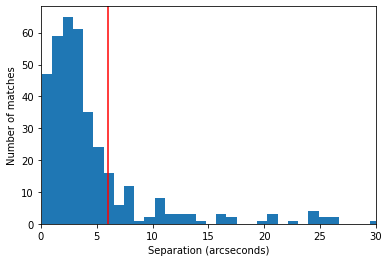

299


Cluster_ID,Cluster_ID_SRC,Cluster_RA,Cluster_DEC,Cluster_z,source_id,source_ra,source_dec,source_redshift,separation,Name,ID_SRC,RA_CORR,DEC_CORR,EXT,EXT_LIKE,ML_FLUX,ML_FLUX_ERR
bytes32,int32,float32,float32,float32,bytes32,float32,float32,float32,float32,str22,int32,float64,float64,float64,float64,float64,float64
eFEDS J085620.7+014649,569,134.08646,1.780459,0.72408,577635649198296192,134.0663,1.7767442,0.7013232,73.78402,eFEDS J085615.8+014637,568,134.06592095439217,1.7769519858923724,0.0,0.0,1.3283442e-13,1.1208479e-14
eFEDS J085620.7+014649,569,134.08646,1.780459,0.72408,577635752277787008,134.11075,1.7883862,1.5986373,91.965324,eFEDS J085626.5+014718,3125,134.11082404541906,1.7884510074558067,0.0,0.0,4.4600273e-14,7.274131e-15


In [183]:
max_separation = 6*u.arcsec
quasar_coords = SkyCoord(ra=eFEDS_gaia_match['source_ra']*u.degree, dec=eFEDS_gaia_match['source_dec']*u.degree)
eFEDS_coords = SkyCoord(ra=eFEDS_main['RA_CORR']*u.degree, dec=eFEDS_main['DEC_CORR']*u.degree)
idx, d2d, d3d = quasar_coords.match_to_catalog_sky(eFEDS_coords)

plt.hist(d2d.arcsec, bins=500)
plt.axvline(max_separation.value, c='r')
plt.xlim(0,30)
plt.xlabel('Separation (arcseconds)')
plt.ylabel('Number of matches')
plt.show()

print(np.count_nonzero(d2d<max_separation))

eFEDS_gaia_match = eFEDS_gaia_match[d2d<max_separation]
eFEDS_main_match = eFEDS_main[idx[d2d<max_separation]]

for col in eFEDS_main_match.colnames:
    eFEDS_gaia_match.add_column(eFEDS_main_match[col], name= col)

eFEDS_gaia_match[eFEDS_gaia_match['Cluster_ID_SRC']==569]

Save table

In [184]:
eFEDS_gaia_match.write('Source_Data/eFEDS_gaia_match.csv', format='csv', overwrite=True)

Plot of eFEDS sources Flux vs matched Gaia source redshift

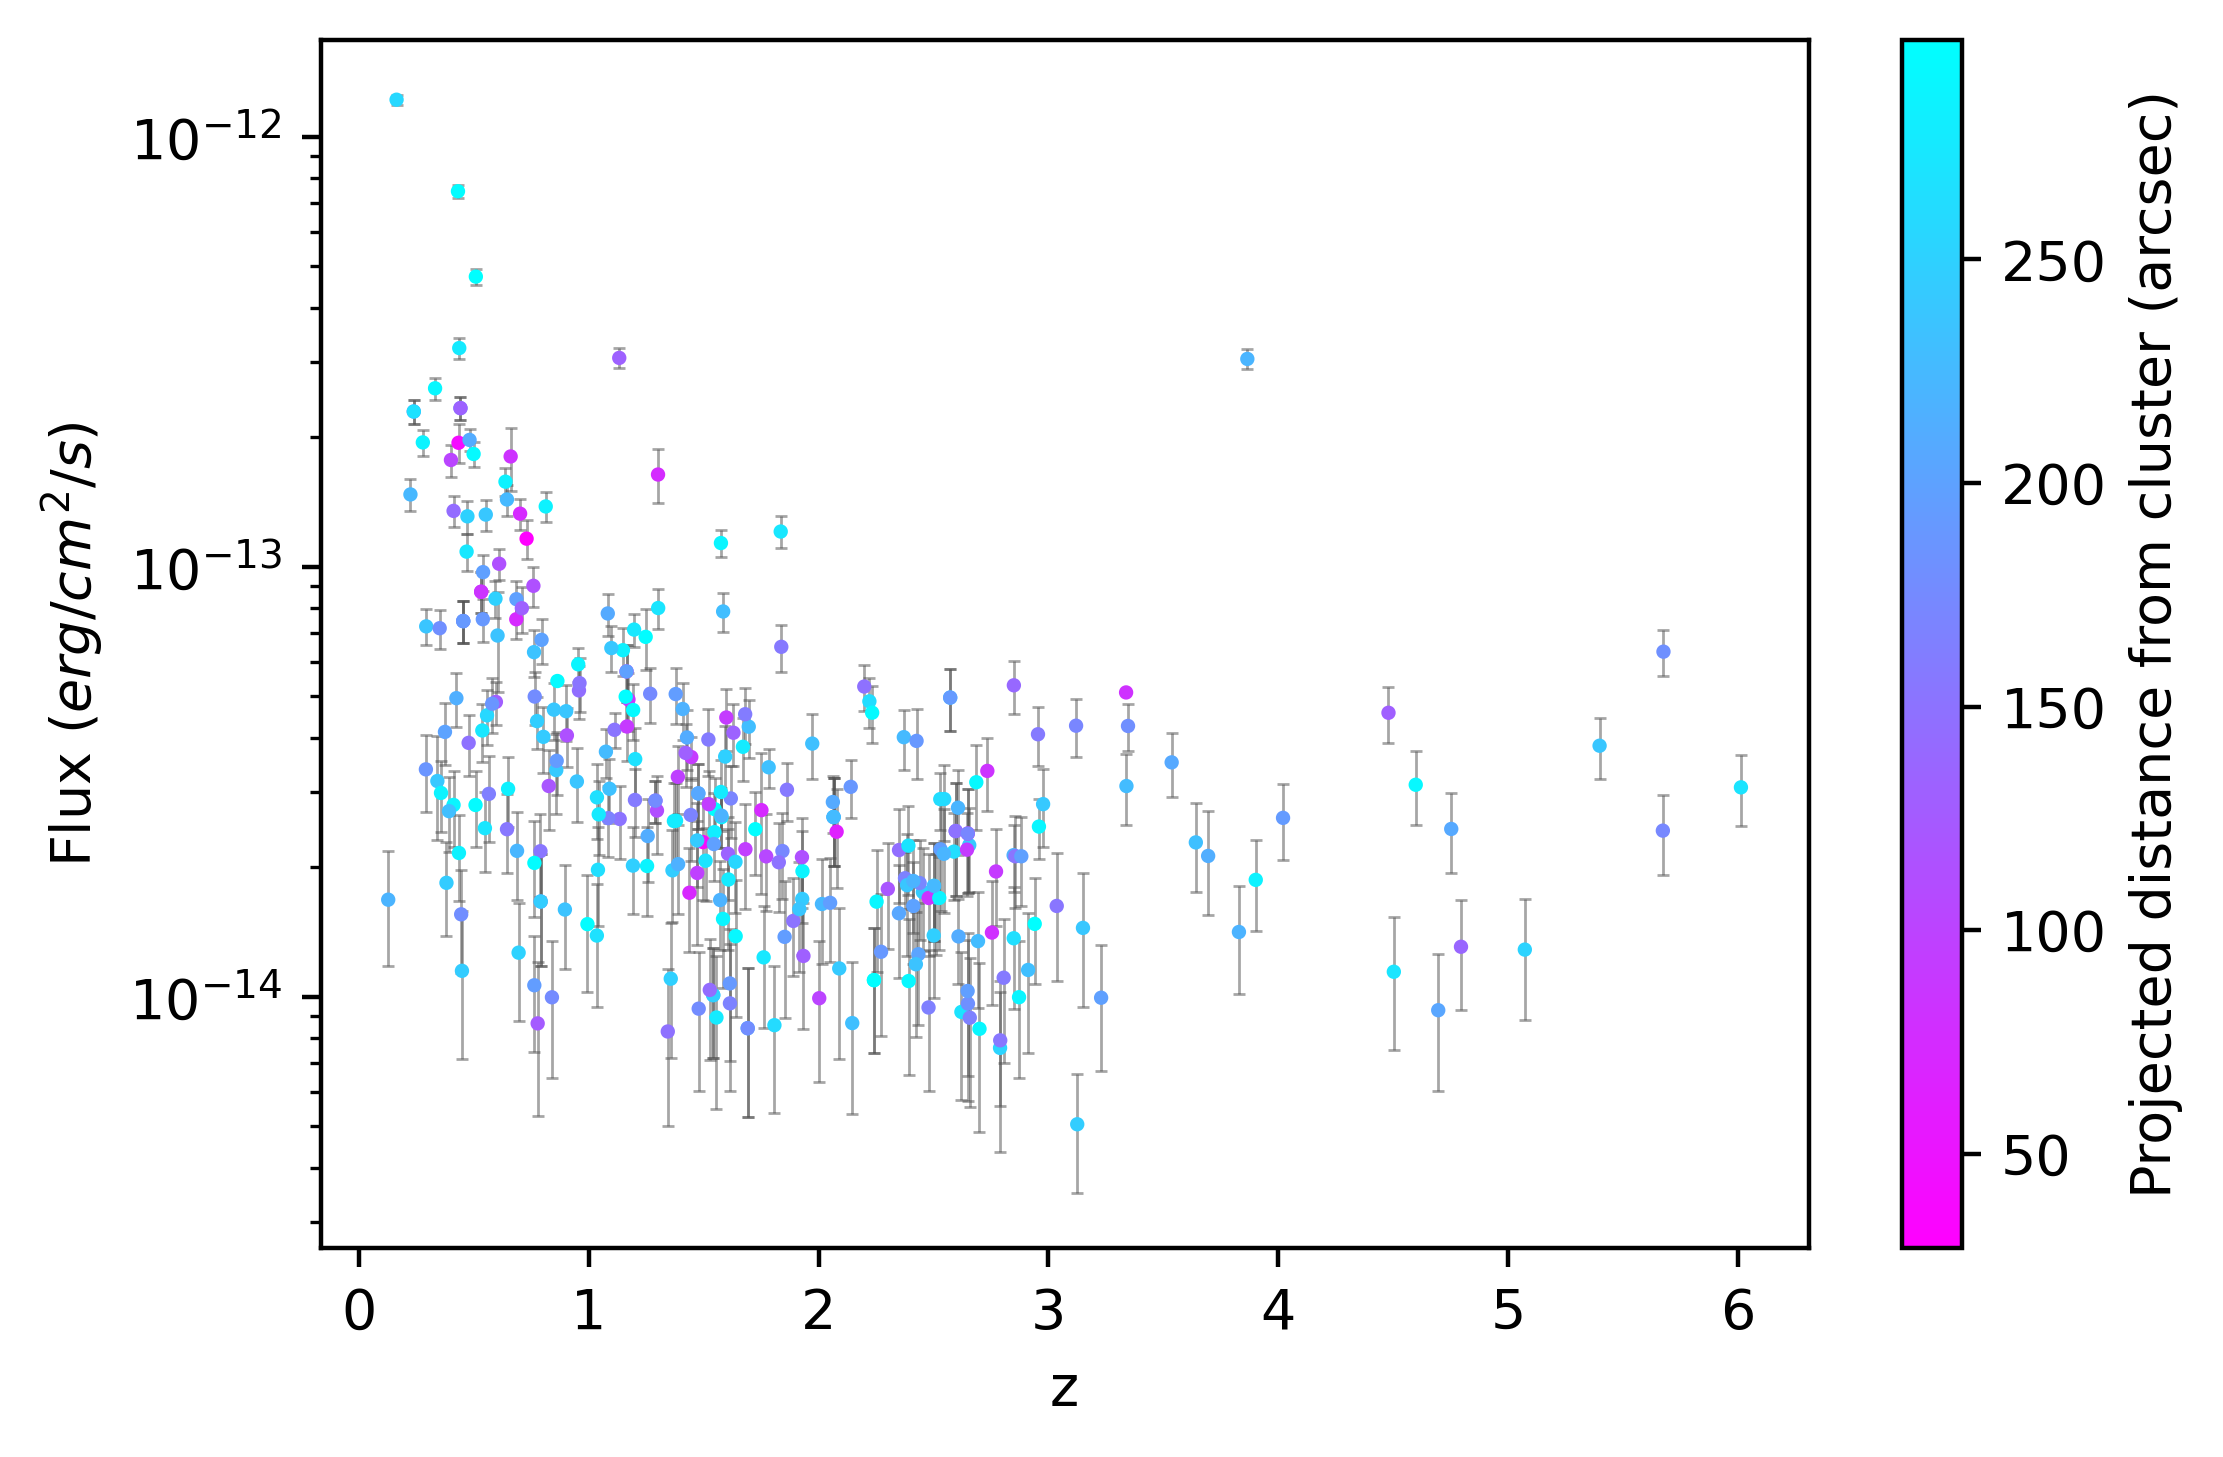

In [185]:

plt.figure(dpi=400)
plt.scatter(eFEDS_gaia_match['source_redshift'], eFEDS_gaia_match['ML_FLUX'],marker='.', c=eFEDS_gaia_match['separation'], cmap='cool_r', s=10)
plt.errorbar(eFEDS_gaia_match['source_redshift'], eFEDS_gaia_match['ML_FLUX'], fmt='none', yerr=eFEDS_gaia_match['ML_FLUX_ERR'], ecolor='#4f4f4f',zorder=-1, elinewidth=0.5, capsize=1, capthick=0.5, alpha =0.5)
plt.ylabel('Flux ($erg/cm^2/s$)')
plt.xlabel('z')
plt.yscale('log')
plt.colorbar().set_label('Projected distance from cluster (arcsec)')
plt.savefig('quasar_flux_redshift.png')
# plt.xscale('log')
plt.show()

In [186]:
print(len(np.unique(eFEDS_gaia_match['Cluster_ID_SRC'])))

223


From the FLux vs Redshift plot there is one obvious outlier around redshift 3.9 where it has a flux an order of magnitude larger than similar redshifts, I have isolated it here so it may be removed although I haven't done a thourough check for other potential outliers (mainly because I don't know how do that)<br>
This particular source could be either a mismatched quasar to xray point source or perhaps due to an error in the flux or redshift calculation.<br>
It could also just be an extremely monstrous quasar.

In [187]:
eFEDS_gaia_match[eFEDS_gaia_match['ID_SRC'] == 146]

Cluster_ID,Cluster_ID_SRC,Cluster_RA,Cluster_DEC,Cluster_z,source_id,source_ra,source_dec,source_redshift,separation,Name,ID_SRC,RA_CORR,DEC_CORR,EXT,EXT_LIKE,ML_FLUX,ML_FLUX_ERR
bytes32,int32,float32,float32,float32,bytes32,float32,float32,float32,float32,str22,int32,float64,float64,float64,float64,float64,float64
eFEDS J083916.7-020552,7669,129.81975,-2.0979366,0.2685,3072428941371798784,129.7963,-2.041398,3.8657851,220.3342,eFEDS J083911.2-020229,146,129.79672382598307,-2.0414890751134833,0.0,0.0,3.0419135e-13,1.5986244e-14


C:\Users\Toby\AppData\Local\Temp\ipykernel_20200\1407776547.py:4: RuntimeWarning: invalid value encountered in true_divide
  y_err = (n_counts_err/n_counts)*y
c:\Users\Toby\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\Toby\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


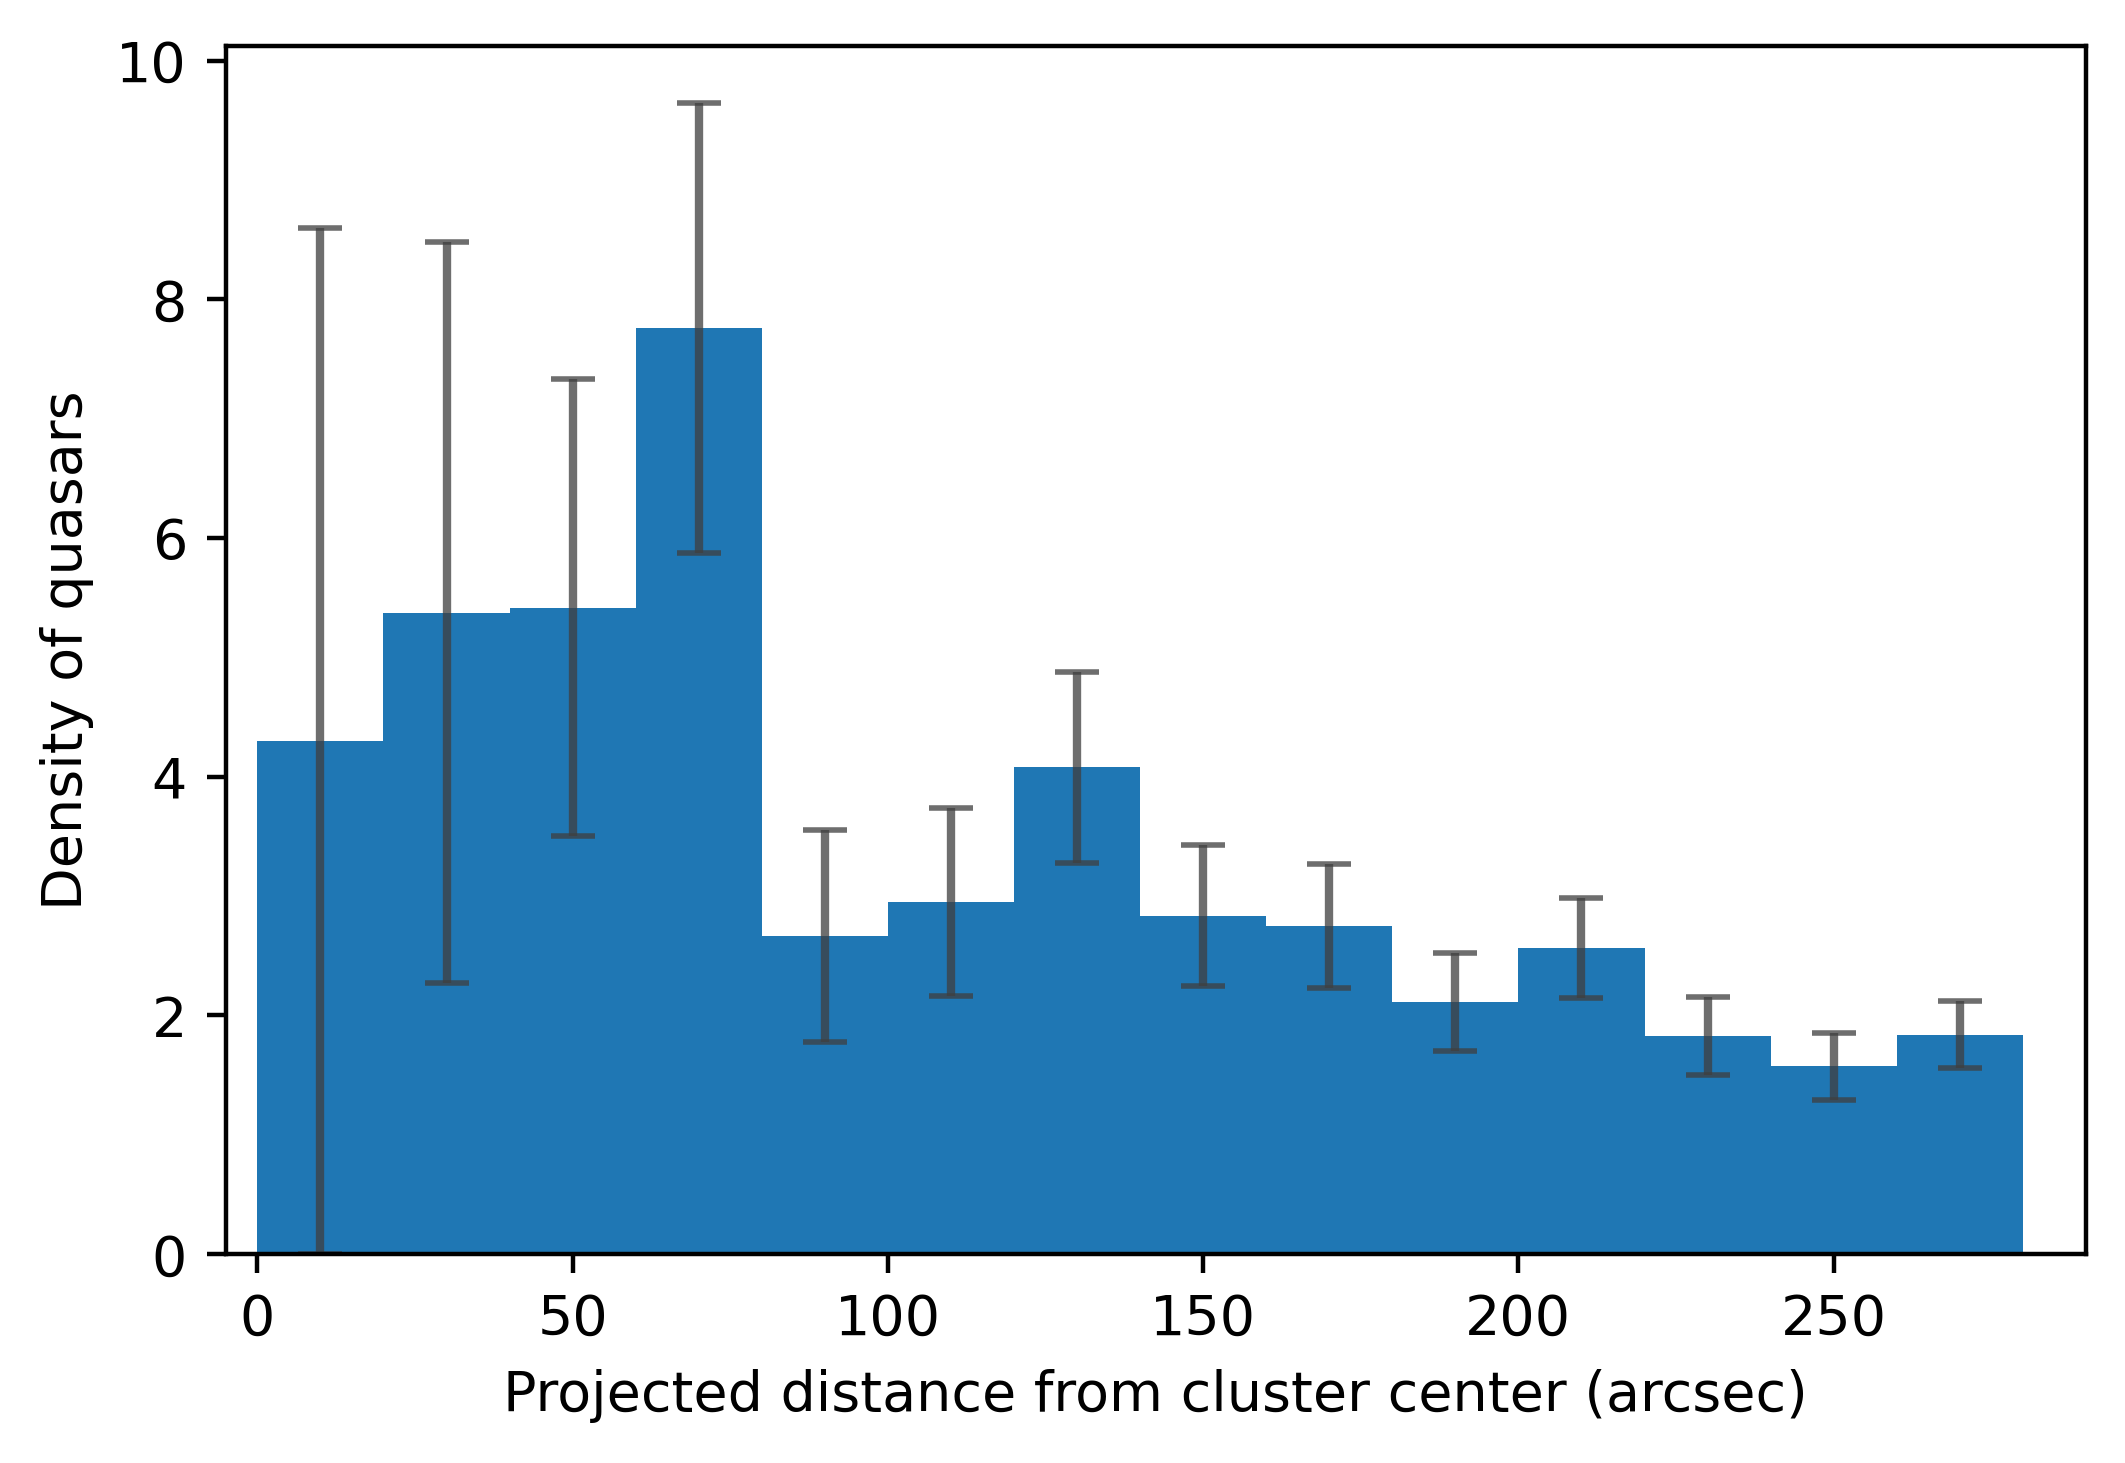

In [188]:
y, bin_edges = np.histogram(eFEDS_gaia_match['separation'], bins=15, weights=3600/(eFEDS_gaia_match['separation']**2), range=(0, 300))
n_counts, _ = np.histogram(eFEDS_gaia_match['separation'], bins=15, range=(0, 300))
n_counts_err = np.sqrt(n_counts)
y_err = (n_counts_err/n_counts)*y
x_values = bin_edges[:-1]-(300/(2*15))
plt.figure(dpi=400)
plt.bar(x_values, y, width=20, yerr=y_err, capsize=4, ecolor='#3f3f3fc0')
plt.xlim(-5, 290)
plt.ylabel('Density of quasars')
plt.xlabel('Projected distance from cluster center (arcsec)')
plt.savefig('quasar_density.png')

# out = plt.hist(eFEDS_gaia_match['separation'], weights=3600/(eFEDS_gaia_match['separation']**2), bins=15, range=(0, 300))

# plt.show()